/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Samples shape: (2062, 64, 64)
Labels shape: (2062, 10)

Training shape: (1752, 64, 64)
1752 sample, 64 x 64 size grayscale image.



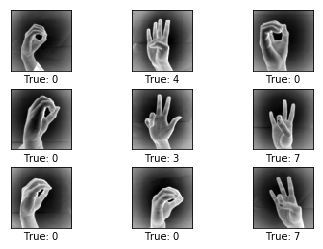

Test shape: (310, 64, 64)
310 sample, 64 x 64 size grayscale image.



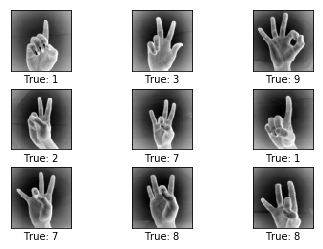

In [1]:
# Configura conjuntos de treinamento e teste 
# X_train, X_test, Y_train, Y_test
%run './functions/SLD-LoadTrainTestSets.ipynb'

In [2]:
import keras
from keras import backend as K
from keras.layers.core import Dense, Dropout, Activation
from keras.models import Model, Input
from keras.applications.mobilenet import MobileNet
from keras.layers import Conv2D, GlobalAveragePooling2D, Reshape
from keras.optimizers import Adam

In [3]:
original_input_shape = (64, 64, 3)
desired_input_shape = (64, 64, 1)
layer_name = 'conv1'

weights = None
include_top = False

adam_lr = 0.0001
nb_epochs = 10
cm_plot_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
validation_split = 0.1
batch_size=10

---

# Adicionando camadas no final
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1024)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 1, 1024)        0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 1024)        0         
_________________________________________________________________
conv_preds (Conv2D)          (None, 1, 1, 10)        ???   
_________________________________________________________________
act_softmax (Activation)     (None, 1, 1, 10)        0         

In [4]:
# Configuração necessária para imagens 64x64
weights = None
include_top = False

In [5]:
base_model = MobileNet(input_shape=original_input_shape,
                       weights=weights,
                       include_top=include_top)
base_model.layers[-1].name

'conv_pw_13_relu'

In [6]:
# Alterando input para grayscale (1 channel)
selected_layer = base_model.get_layer(layer_name)
selected_layer_index = base_model.layers.index(selected_layer)

w = selected_layer.get_weights()
w[0] = w[0].mean(axis=2, keepdims=True)

y = x = Input(shape=desired_input_shape)

attributes = dict(selected_layer.get_config(),
                  name=layer_name + '_1',
                  weights=w)
selected_layer = Conv2D.from_config(attributes)

y = selected_layer(y)

for layer in base_model.layers[selected_layer_index + 1:]:
    y = layer(y)

In [7]:
# Adicionando camadas representadas pelo include_top=True
# camada FC no final da rede
y = GlobalAveragePooling2D()(y)
y = Reshape((1, 1, 1024))(y)
y = Dropout(0.25)(y)
y = Conv2D(10, kernel_size=(1, 1), activation='relu')(y)
y = Activation('softmax')(y)
y = Reshape((10,))(y)

In [8]:
model = Model(inputs=x, outputs=y)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 32, 32, 32)        288       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 32, 32, 32)        128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 32, 32, 32)        0         
__________

In [9]:
len(model.layers)

88

In [10]:
# Congela camadas
# for layer in model.layers:
#     layer.trainable = False

In [11]:
expand_train_X = np.expand_dims(X_train, axis=-1)
expand_test_X = np.expand_dims(X_test, axis=-1)

Train on 1576 samples, validate on 176 samples
Epoch 1/10
1576/1576 [==============================] - 130s 83ms/step - loss: 2.3154 - acc: 0.1022 - val_loss: 2.3067 - val_acc: 0.1080
Epoch 2/10
1576/1576 [==============================] - 123s 78ms/step - loss: 2.2668 - acc: 0.1516 - val_loss: 2.2160 - val_acc: 0.1761
Epoch 3/10
1576/1576 [==============================] - 124s 79ms/step - loss: 2.2044 - acc: 0.2030 - val_loss: 3.0633 - val_acc: 0.1477
Epoch 4/10
1576/1576 [==============================] - 129s 82ms/step - loss: 2.1048 - acc: 0.2646 - val_loss: 2.1080 - val_acc: 0.2102
Epoch 5/10
1576/1576 [==============================] - 123s 78ms/step - loss: 2.0033 - acc: 0.2989 - val_loss: 2.2956 - val_acc: 0.2443
Epoch 6/10
1576/1576 [==============================] - 124s 79ms/step - loss: 1.8619 - acc: 0.3566 - val_loss: 2.0517 - val_acc: 0.2898
Epoch 7/10
1576/1576 [==============================] - 85s 54ms/step - loss: 1.7371 - acc: 0.4105 - val_loss: 1.9413 - val_acc: 0.

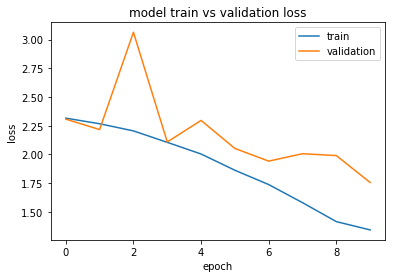

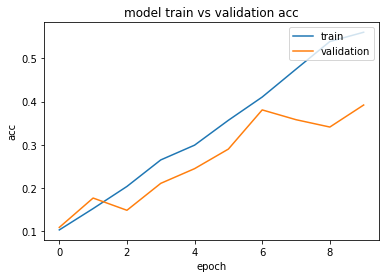

Acertos: 123 / 310
Confusion matrix, without normalization
[[19  4  1  2  0  0  0  5  1  0]
 [ 2 13  4  1  0  0  0  0  4  0]
 [ 0  8  9  1  0  0  0  9  5  2]
 [ 0  0  1 16  0  6  0  0  1  6]
 [ 0  2  1  4  0  3  0 10  5  5]
 [ 0  0  0  7  0 23  0  0  1  4]
 [ 0  0  5  1  0  0  0 12  4  6]
 [ 0  3  1  5  0  1  0 14 16  2]
 [ 1  1  1  1  0  1  0  4 14  5]
 [ 1  0  0  3  0  2  0  0  6 15]]
CPU times: user 29min 46s, sys: 4min 1s, total: 33min 47s
Wall time: 17min 51s


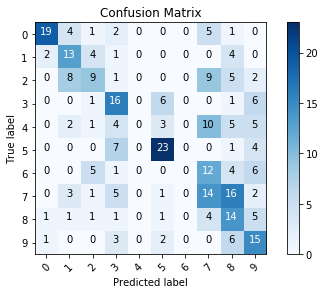

In [12]:
%%time
acertos, pred = execute_model(model, expand_train_X, Y_train, expand_test_X, Y_test,
                              validation_split, batch_size, cm_plot_labels, 
                              adam_lr, nb_epochs)

In [ ]:
# model.compile(Adam(lr=adam_lr), 
#               loss='categorical_crossentropy', 
#               metrics=['accuracy'])

# new_X = expand_dims(X_train, axis=-1)

# hist = model.fit(new_X, 
#                  Y_train,
#                  epochs=nb_epochs, 
#                  steps_per_epoch=10,
#                  shuffle=True, 
#                  verbose=1)

---